In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from datetime import datetime
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor

from funciones_OD import *

#pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow

ruta = "F:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
sensor = "pm25"
redondeo = 4
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
#entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
#coor_CS = pd.read_csv(ruta+"coordenadas_CS.csv",sep=",")
variables = ['pm25']#,'humedad_relativa', 'temperatura'


In [17]:
# DOE TECNICA LOF

pd.options.mode.chained_assignment = None  # default='warn'

#porcentaje = 0.6
#entreno, datos = df_mix (entreno,porcentaje) 

for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

#datos_ori, datos2, outliers = synthetic_data(datos,0.1,1)

datos2 = datos.copy()

nodos = datos2.codigoSerial.unique().tolist()
fechas = datos2.fecha.unique().tolist()
datos2 = datos2.assign(LOF="N")

Evaluacion_ident_outliers_lof = pd.DataFrame(columns =["Technique","Variable","Precision","Recall","F1","Accuracy","Time"])
ident_outliers = pd.DataFrame()
now = datetime.now()
time_lof = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
vecinos = [20]
contami = [0.2]
#vecinos = [100]
#contami = [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .11, .12, .13, .14, .15, .16, .17, .18, .19, .20]

cont = 0
for i in nodos:
    fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)

    for j in fechas:
        
        fil = fild.loc[fild.loc[:,"fecha"] == j]
        fil.reset_index(inplace=True, drop=True)

        if (len(fil)<=0):
            continue

        datos_lof = fil.loc[:,["pm25", "pm25_outlier"]]
        datos_lof['pm25_ori'] = [d1 if d2 == 'N' else float(d2) for d1, d2 in zip(datos_lof['pm25'], datos_lof['pm25_outlier'])]
        datos_lof = datos_lof.loc[:,["pm25","pm25_ori"]]

        for vec in vecinos:
            for cont in contami:
                
                # Entrenamiento
                lof_inicio = datetime.now()
                #model1 = LocalOutlierFactor(n_neighbors = vec, metric = "euclidean")
                model1 = LocalOutlierFactor(n_neighbors = vec, metric = "euclidean", contamination=cont)
                
                # Detección
                y_pred = model1.fit_predict(datos_lof)
                outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
                
                # filter outlier values
                margen = str(vec)+"/"+str(cont)
                #print("No. outliers detected for",margen,":", len(outlier_index[0]))
                fil.loc[list(outlier_index[0]),"LOF"] = 'S'
                lof_fin = datetime.now()
                time_lof = time_lof +(lof_fin-lof_inicio)
                #outlier_values = data2.iloc[outlier_index]

                ident_outliers = pd.concat([ident_outliers,fil],ignore_index=True)


######  CONFUSION MATRIX #########
real = ident_outliers.pm25_outlier.tolist()
real = ['S' if value!='N' else value for value in real]
predicho = ident_outliers.LOF.tolist()

acc, re, pre, f1 = confu_matrix_no_print (real,predicho)
        
Evaluacion_ident_outliers_lof.loc[len(Evaluacion_ident_outliers_lof)]=["LOF", margen, pre, re, f1, acc, time_lof.time()]

Evaluacion_ident_outliers_lof



,Technique,Variable,Precision,Recall,F1,Accuracy,Time
0,LOF,20/0.2,0.468677,0.625065,0.53569,0.891637,00:00:00.163549


(0.8916366089731946,
 0.6250648676699533,
 0.4686770428015564,
 0.5356904603068712)

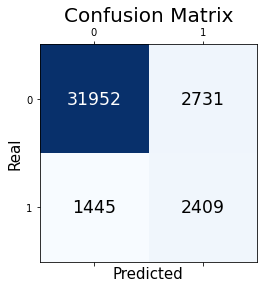

In [19]:
confu_matrix (real[0:len(predicho)],predicho)

C:\Users\FERNAN~1\AppData\Local\Temp/ipykernel_6576/2505645714.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = ident_outliers[0:300][ident_outliers['LOF'] == 'S']
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


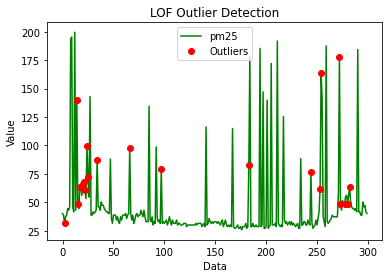

In [20]:
outliers = ident_outliers[0:300][ident_outliers['LOF'] == 'S']
plt.plot(ident_outliers[0:300].index, ident_outliers[0:300].pm25, color="green",label="pm25")
plt.plot(outliers.index, outliers.pm25, 'o', color="red",label="Outliers")
plt.title('LOF Outlier Detection')
plt.legend(loc='upper center')
plt.xlabel('Data')
plt.ylabel('Value')
plt.savefig("LOF_result.eps", dpi=200, bbox_inches='tight') 
plt.show()

In [21]:
ident_outliers[0:300][ident_outliers['LOF'] == 'S']

C:\Users\FERNAN~1\AppData\Local\Temp/ipykernel_6576/1985938553.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ident_outliers[0:300][ident_outliers['LOF'] == 'S']


,codigoSerial,fecha,hora,temperatura,humedad_relativa,pm25,pm25_outlier,LOF
2,2,2020-02-01,00:02:00,22.61,71.87,31.4366,N,S
14,2,2020-02-01,00:14:00,22.38,74.38,139.8281,47.337,S
15,2,2020-02-01,00:15:00,22.34,74.74,48.7825,N,S
17,2,2020-02-01,00:21:00,22.20,75.97,63.2374,N,S
18,2,2020-02-01,00:22:00,22.19,76.28,63.2374,N,S
20,2,2020-02-01,00:24:00,22.20,76.87,66.1284,N,S
21,2,2020-02-01,00:25:00,22.21,77.05,67.5739,N,S
22,2,2020-02-01,00:26:00,22.21,77.06,60.3464,N,S
24,2,2020-02-01,00:28:00,22.23,76.92,99.3747,N,S
25,2,2020-02-01,00:29:00,22.23,76.35,71.9104,N,S
